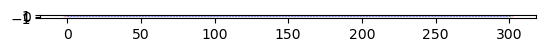

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import time
from numpy import sqrt,pi,kron
from scipy.sparse.linalg import eigsh
import scipy.sparse.linalg as sla

#pauli matrix
sigma_0 = np.array([[1, 0],[0, 1]])
sigma_x = np.array([[0, 1],[1, 0]])
sigma_y = np.array([[0, -1j],[1j, 0]])
sigma_z = np.array([[1, 0],[0, -1]])

tau_0 = sigma_0
tau_x = sigma_x
tau_y = sigma_y
tau_z = sigma_z


'''fixed parameters'''
hbar = 1.055e-34    #J.S  
me = 9.109e-31    #kg
meff = 0.03*me
delta0 = 0.12   #meV


a = 1e-8 #m
L = 300

#g·mu_B的值
gmu = 1.4470954503  #meV/T
meV = 1.60217e-22
t = hbar**2/(2*meff*a**2)/meV   #量纲为meV
gamma = 0.15 #meV
alpha = 0.8  #约化Rashba，等于alpha/a,单位为meV


#barrier on edge
V = 15 #meV

'''变化参数'''
B = 0.4
mu = 0.0


#self energy
def self_eng(omega):
    return -gamma/sqrt(delta0**2 - omega**2) * (omega * kron(tau_0,sigma_0) + delta0 * kron(tau_x,sigma_0))

def sys_conds(B,omega,mu,mu_lead=2*t,t_lead=t):
    lat = kwant.lattice.square(a=1,norbs=4,name='wire')
    sys = kwant.Builder()
    es = 1e-3
    
    def system_shape(pos):
        return -1 - es < pos[0] < L + 1 + es and 0-es < pos[1]<1
    def lead_left(pos):
        return 0-es < pos[1] < 1 
    def lead_right(pos):
        return 0-es < pos[1] < 1 
    
    def onsite_SC(site):

        #boundary onsite barrier
        if site.pos[0] == -1  or site.pos[0] == L + 1:
            return (2 * t_lead + V - mu_lead ) * kron(tau_z,sigma_0)
        else:
            return (2 * t - mu) * kron(tau_z,sigma_0) + self_eng(omega) + 1/2 * gmu * B * kron(tau_0,sigma_x) 
        
    def hoppingx(site1,site2):
        x1 = site1.pos[0]
        x2 = site2.pos[0]

        # print(x1,x2)

        #boundary hopping 
        if x2 == -1 or x1 == L + 1:
            return -t_lead * kron(tau_z, sigma_0)
        else:
            return -t * kron(tau_z,sigma_0) + 1j * alpha/2 * kron(tau_z,sigma_y) 


    sys[lat.shape(system_shape, (0, 0))] = onsite_SC
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = hoppingx

    #left lead
    left = kwant.Builder(kwant.TranslationalSymmetry((-1,0)))
    left[lat.shape(lead_left, (-2 , 0))] = (2 * t_lead - mu_lead) * kron(tau_z,sigma_0)
    left[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t_lead * kron(tau_z,sigma_0)
    sys.attach_lead(left)

    # right lead
    right = kwant.Builder(kwant.TranslationalSymmetry((1,0)))
    right[lat.shape(lead_right, (L+2 , 0))]= (2 * t_lead - mu_lead) * kron(tau_z,sigma_0) 
    right[kwant.builder.HoppingKind((1, 0), lat, lat)] = -t_lead * kron(tau_z,sigma_0)
    sys.attach_lead(right)
    return sys

def local_cond(S):
    ree = np.sum(np.abs(S[:len(S)//2, :len(S)//2])**2)
    reh = np.sum(np.abs(S[:len(S)//2, len(S)//2:])**2)
    # print(np.shape(S)[0]//2,ree,reh,ree+reh,2-ree+reh)
    return (len(S)//2 - ree + reh)

def nonlocal_cond(S):
    ree = np.sum(np.abs(S[:len(S)//2, :len(S)//2])**2)
    reh = np.sum(np.abs(S[:len(S)//2, len(S)//2:])**2)
    # print(np.shape(S)[0]//2,ree,reh)
    return (ree - reh)


def cal_local_conds(sys,omega):
    smatrix = kwant.smatrix(sys,energy=omega,check_hermiticity=True)
    cond=local_cond(np.array(smatrix.submatrix(0,0)))
    return cond

def cal_nonlocal_conds(sys,omega):
    smatrix = kwant.smatrix(sys,energy=omega,check_hermiticity=True)
    cond=nonlocal_cond(np.array(smatrix.submatrix(0,1)))
    return cond

sys = sys_conds(B,0,mu,mu_lead=2*t,t_lead=t).finalized()

def site_color(site):
    # print(site)
    x = site
    if x == 0 or x == L+2 :
        return 'green'    # 边界格点
    else:
        return 'blue'   # 中间区域格点
kwant.plot(sys, site_color=site_color)

ham = sys.hamiltonian_submatrix()



# T=0, 1D conductance

In [ ]:
%matplotlib tk


def main():
    '''lead bands'''
    system = sys_conds(B = 0,omega = 0,mu = 0)
    system = system.finalized()
    kwant.plot(system)

    band_lead = kwant.physics.Bands(system.leads[0])
    momenta = np.linspace(-pi, pi, 2001)
    eng_lead = [band_lead(k) for k in momenta]

    '''plot'''    
    plt.figure()
    plt.plot(momenta, eng_lead,'b')
    plt.xlabel('k')
    plt.ylabel('engs')
    plt.title('lead[0]')
    plt.show()

    t1 = time.time()
    omega = np.linspace(-0.1,0.1,101)

    Conds_LL = np.zeros(len(omega))    
    Conds_LR = np.zeros(len(omega))
    for i in range(len(omega)):

        system = sys_conds(B,omega[i],mu).finalized()
        #GLL
        Conds_LL[i] = cal_local_conds(system,omega[i])

        #GLR
        Conds_LR[i] = cal_nonlocal_conds(system,omega[i])
        
    #GLL
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.plot(omega, Conds_LL/2)  
    plt.xlabel(r"$V_{bias}$")
    plt.ylabel("conductance [$2e^2/h$]")
    plt.title(f'B={B},$\\mu$={mu}')
    plt.show()
    
    plt.subplot(1,2,2)
    plt.plot(omega, Conds_LR/2)  
    plt.xlabel(r"$V_{bias}$")
    plt.ylabel("conductance [$2e^2/h$]")
    plt.title(f'B={B},$\\mu$={mu}')
    plt.show()    
    t2 = time.time()
    print(t2-t1)
    
if __name__ == '__main__':
    main()

# bias = 0,T=0，2D conds

In [ ]:
omega = 0.00
B = np.linspace(0,0.8,15)
mu = np.linspace(0,0.6,15)


'''GLL'''
t1 = time.time()
GLL = np.zeros((len(B),len(mu)))
for i in range(len(B)):
    for j in range(len(mu)):
        system = sys_conds(B[i],omega,mu[j]).finalized()
        GLL[i][j] = cal_local_conds(system,omega)
        # print('B=',B[i],'mu=',mu[j],GLL[i][j])
        
'''GLR'''
GLR = np.zeros((len(B),len(mu)))
for i in range(len(B)):
    for j in range(len(mu)):
        system = sys_conds(B[i],omega,mu[j])
        system = system.finalized()
        GLR[i][j] = cal_nonlocal_conds(system,omega)
        # print('B=',B[i],'mu=',mu[j],GLL[i][j])

t2 = time.time()
print(t2-t1)

def plot_cond(x,y,G,title):
    X, Y = np.meshgrid(x, y)
    # 绘制第一个图
    Z = np.array(G).T  
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('$\\mu$')

    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    cbar = plt.colorbar()
    plt.show()

plot_cond(B,mu,GLL/2,'T=0,GLL')
plot_cond(B,mu,GLR/2,'T=0,GLR')

# mu = 0, T=0, 2D conductance

872.2092761993408


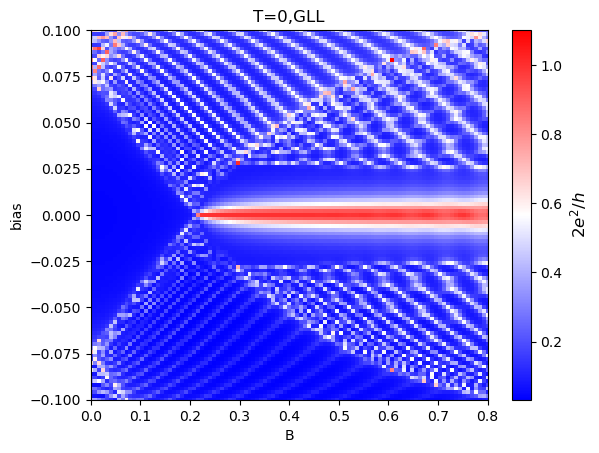

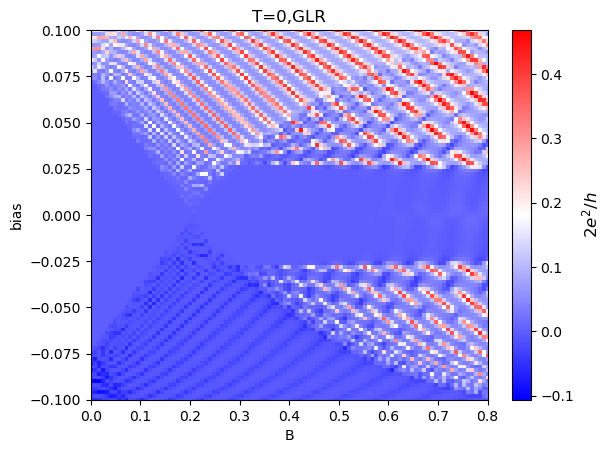

In [3]:
es = 1e-6
mu = 0
B = np.linspace(0,0.8,101)
omega = np.linspace(-0.1,0.1,101)


t1 = time.time()
GLL = np.zeros((len(B),len(omega)))
GLR = np.zeros((len(B),len(omega)))

for i in range(len(B)):
    for j in range(len(omega)):
        system = sys_conds(B[i],omega[j],mu).finalized()
        GLL[i][j] = cal_local_conds(system,omega[j])
        GLR[i][j]=cal_nonlocal_conds(system,omega[j])
t2 = time.time()
print(t2-t1)

def plot_cond(x,y,G,title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(G).T  
    plt.figure()
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('bias')

    plt.xlim(np.min(x),np.max(x))
    plt.ylim(np.min(y),np.max(y))
    # 添加 colorbar 并标注
    cbar = plt.colorbar()  
    cbar.set_label('$2e^2/h$', fontsize=12)  # 设置 colorbar 的标注
    plt.show()

plot_cond(B,omega,GLL/2,'T=0,GLL')
plot_cond(B,omega,GLR/2,'T=0,GLR')

In [11]:
# plot_cond(B,omega,GLL/2,'T=0,GLL')
plot_cond(B,omega,GLR/2,'T=0,GLR')

# with tempreture

$G(E_{i})=\frac{2e^{2}}{h}\int\bar{T(E)}F_{T}(E-E_{i})dE$  \
with $F_{T}(E-E_{i})$ being the thermal broadening function  \
$F_{T}(E-E_{i})=-\frac{\partial}{\partial E}(\frac{1}{exp[(E-E_{i})/k_{B}T+1]})=\frac{1}{4k_{B}T}\frac{1}{cosh^{2}[\frac{E-E_{i}}{2*k_{B}T}]}$

In [15]:
%matplotlib tk
bias=np.linspace(-0.1,0.1,201)

#KT energy in 50mK
KT= 4.31*1e-3 #meV

#all params are numbers
def dF(E,V,KT):
    return 1/(4*KT)*1/(np.cosh((E-V)/(2.*KT))**2)


def Finite_Temp_Conds(G):
    #dimension of finite conds 
    g = np.zeros((len(G[:,0]),len(bias)))

    # rectangular integral
    for i in range(len(bias)):
        for j in range(len(omega)):
            g[:,i] += G[:,j] * dF(omega[j],bias[i],KT) * (omega[2] - omega[1])

    print(np.array(g).shape)

    return g

g = Finite_Temp_Conds(GLR)

def plot_cond_T(x,y,cond,title):
    X, Y = np.meshgrid(x, y)
    Z = np.array(cond).T
    plt.pcolormesh(X, Y, Z, cmap='bwr', shading='auto') 
    plt.title(title)
    plt.xlabel('B')
    plt.ylabel('$V_{bias}$')
    
    cbar = plt.colorbar()  
    plt.savefig('GLR.svg', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


plt.figure()

plot_cond_T(B,bias,g/2,'T=50mK')



(101, 201)
